In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import random
from random import shuffle

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, BatchNormalization
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%pwd

'/content'

In [0]:
#df_train = pd.read_csv('./mitbih_train.csv')
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/mitbih_train.csv', header=None)
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/mitbih_test.csv', header=None)

In [0]:
df_train.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,...,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000,87554.000000
mean,0.890360,0.758160,0.423972,0.219104,0.201127,0.210399,0.205808,0.201773,0.198691,0.196757,0.198778,0.203550,0.208776,0.212885,0.218393,0.224966,0.231377,0.237123,0.242582,0.247923,0.253749,0.259748,0.266244,0.272734,0.279355,0.285588,0.291808,0.297672,0.303384,0.308795,0.313890,0.318454,0.322087,0.324891,0.326737,0.327817,0.327931,0.326746,0.324326,0.320537,...,0.030729,0.029582,0.028531,0.027573,0.026875,0.025771,0.024823,0.023932,0.023060,0.022458,0.021809,0.021245,0.020623,0.020026,0.019534,0.019053,0.018592,0.017664,0.016740,0.015722,0.014402,0.013024,0.011625,0.010262,0.008929,0.008056,0.007278,0.006531,0.005981,0.005479,0.005025,0.004628,0.004291,0.003945,0.003681,0.003471,0.003221,0.002945,0.002807,0.473376
std,0.240909,0.221813,0.227305,0.206878,0.177058,0.171909,0.178481,0.177240,0.171778,0.168357,0.171796,0.176496,0.180274,0.184101,0.186963,0.190002,0.193899,0.198465,0.202855,0.207166,0.211187,0.214821,0.218450,0.221486,0.224031,0.225848,0.227133,0.227830,0.228436,0.228871,0.228760,0.228393,0.227472,0.226180,0.224659,0.223110,0.221352,0.219258,0.216884,0.214168,...,0.116516,0.114463,0.112686,0.111103,0.110513,0.108566,0.106493,0.104591,0.102658,0.101395,0.100201,0.099386,0.098327,0.096635,0.095729,0.095368,0.095055,0.092902,0.091118,0.088574,0.084638,0.079949,0.075307,0.069892,0.063994,0.060074,0.056404,0.052840,0.050006,0.046693,0.044154,0.042089,0.040525,0.038651,0.037193,0.036255,0.034789,0.032865,0.031924,1.143184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.921922,0.682486,0.250969,0.048458,0.082329,0.088416,0.073333,0.066116,0.065000,0.068639,0.070543,0.069182,0.068293,0.067744,0.070175,0.072993,0.074803,0.075972,0.076923,0.077872,0.079442,0.081911,0.085938,0.090032,0.094595,0.098901,0.103960,0.109348,0.114754,0.120730,0.127946,0.135962,0.144295,0.151852,0.157895,0.161035,0.161133,0.159383,0.157343,0.155388,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [0]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


(array([72471.,  2223.,  5788.,   641.,  6431.]), array([0, 1, 2, 3, 4, 5]), <a list of 5 Patch objects>)


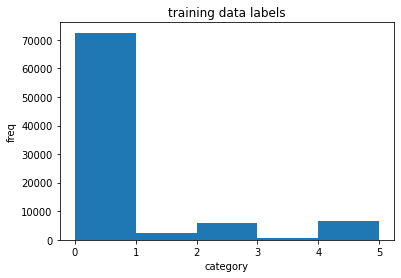

In [0]:
plt.figure(figsize=(6,4))
data_tr = plt.hist(df_train.iloc[:, -1],[0,1,2,3,4,5] )
plt.title('training data labels')
plt.ylabel('freq')
plt.xlabel('category')
print(data_tr)

In [0]:
set(df_train.iloc[:,-1])

{0.0, 1.0, 2.0, 3.0, 4.0}

In [0]:
df_test.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,...,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000,21892.000000
mean,0.894410,0.761902,0.426627,0.221596,0.201676,0.209891,0.204805,0.200992,0.197634,0.196022,0.197905,0.202436,0.207303,0.211524,0.216840,0.223455,0.229845,0.235463,0.240701,0.245976,0.251751,0.257664,0.263788,0.270541,0.276921,0.283179,0.289342,0.295346,0.301180,0.306478,0.311708,0.316235,0.319868,0.322814,0.324713,0.325812,0.325856,0.324729,0.322518,0.319147,...,0.030044,0.028963,0.027824,0.026607,0.025425,0.024429,0.023681,0.022907,0.022260,0.021632,0.020902,0.020205,0.019503,0.019055,0.018643,0.018237,0.017482,0.016573,0.015762,0.014770,0.013538,0.012467,0.011263,0.010013,0.008845,0.007798,0.007057,0.006127,0.005744,0.005194,0.004588,0.004327,0.004020,0.003789,0.003638,0.003459,0.003166,0.003000,0.002946,0.473689
std,0.234560,0.218659,0.228572,0.208711,0.177727,0.172194,0.177946,0.176142,0.170228,0.166707,0.169880,0.174435,0.178156,0.182113,0.184688,0.187600,0.191432,0.195809,0.200435,0.204641,0.208835,0.212702,0.216295,0.219479,0.222084,0.224107,0.225231,0.226223,0.226847,0.227060,0.226925,0.226796,0.225430,0.223759,0.222196,0.220765,0.218938,0.217264,0.215056,0.212746,...,0.115209,0.113678,0.111878,0.110034,0.107466,0.105066,0.103549,0.102304,0.101056,0.099724,0.098239,0.096409,0.094837,0.093730,0.093932,0.093976,0.091960,0.089597,0.087863,0.085269,0.082142,0.079359,0.075340,0.070434,0.065435,0.060256,0.056703,0.051875,0.049754,0.046440,0.043128,0.042187,0.040255,0.039397,0.038535,0.037717,0.035903,0.035522,0.035266,1.143447
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.924260,0.683366,0.251197,0.050505,0.082873,0.087912,0.072663,0.065997,0.064516,0.068493,0.070731,0.069104,0.068293,0.067699,0.069685,0.072285,0.074232,0.075167,0.076410,0.076923,0.078227,0.080584,0.083483,0.088026,0.092918,0.097378,0.102124,0.108246,0.113267,0.119519,0.126045,0.134274,0.142857,0.151260,0.157210,0.160407,0.160612,0.158299,0.156744,0.154839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

Preprocessing data augmentation

In [0]:
#data augmentation 
df_pos0 = df_train[df_train.iloc[:,187]== 0.0] 
df_pos1 = df_train[df_train.iloc[:,187]== 1.0]  #use boolean index on df
df_pos2 = df_train[df_train.iloc[:,187]== 2.0]
df_pos3 = df_train[df_train.iloc[:,187]== 3.0]
df_pos4 = df_train[df_train.iloc[:,187]== 4.0]
pos0 = np.array(df_pos0.iloc[:,:-1])
pos1 = np.array(df_pos1.iloc[:,:-1])
pos2 = np.array(df_pos2.iloc[:,:-1])
pos3 = np.array(df_pos3.iloc[:,:-1])
pos4 = np.array(df_pos4.iloc[:,:-1])

In [0]:
print(pos0.shape)
print(pos1.shape)
print(pos2.shape)
print(pos3.shape)
print(pos4.shape)

(72471, 187)
(2223, 187)
(5788, 187)
(641, 187)
(6431, 187)


In [0]:

def createnoise(loops, data):

    copied_data = np.copy(data)  #must use np.copy else data is being recycled
    newDict = {}
    #indexList = []
    for i in range(copied_data.shape[0]):
        indexList = []
        for j in range(copied_data.shape[1]):
            if copied_data[i][j] != 0.0 and copied_data[i][j] != 1.0:
                indexList.append(j)
        newDict[i] = indexList    
 
    tempDict = {}  # each loop# will map to a full set of data
    dataDict = newDict #just for reassignment ease
    for k in range(loops):
         
        d = np.copy(data)  #must use np.copy else data is being recycled
        for i in range(d.shape[0]):
            for j in dataDict[i]:
                d[i][j] = d[i][j] + np.random.uniform(-0.06, 0.06)
        datacopy = np.copy(d)
        tempDict[k] = datacopy

    a = tempDict[0]
    if loops == 1:
        return a
    for i in range(1, loops):
        total = np.concatenate((a, tempDict[i]), axis=0)
        print('total', total.shape)
        a = total
         
    return total

In [0]:
#need to add y label and concate to original data set
#create 10000 data points for each category
n1 = createnoise(5, pos1)
n2 = createnoise(2, pos2)
n3 = createnoise(16,pos3)
n4 = createnoise(2, pos4)


total (4446, 187)
total (6669, 187)
total (8892, 187)
total (11115, 187)
total (11576, 187)
total (1282, 187)
total (1923, 187)
total (2564, 187)
total (3205, 187)
total (3846, 187)
total (4487, 187)
total (5128, 187)
total (5769, 187)
total (6410, 187)
total (7051, 187)
total (7692, 187)
total (8333, 187)
total (8974, 187)
total (9615, 187)
total (10256, 187)
total (12862, 187)


In [0]:
#create labels for each category
v1 = np.full((10000,1), 1)
v2 = np.full((10000,1), 2)
v3 = np.full((10000,1), 3)
v4 = np.full((10000,1), 4)

In [0]:
#prune to 10000 obs each
n1 = n1[:10000, :]
n2 = n2[:10000, :]
n3 = n3[:10000, :]
n4 = n4[:10000, :]

In [0]:
#add y label back in
dn1 = np.append(n1, v1, axis=1)
dn2 = np.append(n2, v2, axis=1)
dn3 = np.append(n3, v3, axis=1)
dn4 = np.append(n4, v4, axis=1)

In [0]:
#include category 0 data - normal
d0_ = df_pos0.iloc[:10000,:]
d0 = np.array(d0_)
d0.shape

(10000, 188)

In [0]:
tmplist = [dn1, dn2, dn3, dn4]
df0 =pd.DataFrame(d0)
for i in tmplist:
    df_ = pd.DataFrame(i)
    df0 = df0.append(df_)

In [0]:
#df0 is the new data set with noise n=50000 categories 0-4; it is balanced with 10000 in each category
df0.describe()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.840527,0.737038,0.481901,0.314547,0.273317,0.264786,0.249447,0.236326,0.223571,0.204621,0.195495,0.199348,0.208755,0.215833,0.223835,0.234548,0.244612,0.252361,0.258644,0.264787,0.271844,0.279846,0.288175,0.297464,0.306762,0.316448,0.325462,0.334533,0.343618,0.352018,0.360117,0.367707,0.373265,0.378557,0.381915,0.384060,0.384609,0.383021,0.379657,0.374522,...,0.034237,0.033492,0.032781,0.031961,0.031537,0.030969,0.030443,0.030046,0.029725,0.029110,0.028627,0.027842,0.026947,0.026325,0.025392,0.024756,0.024604,0.023670,0.022714,0.021591,0.020679,0.019667,0.018895,0.018105,0.017281,0.016562,0.016056,0.015571,0.014968,0.014602,0.014060,0.013585,0.012917,0.012230,0.011805,0.011454,0.011111,0.010623,0.010355,2.000000
std,0.282432,0.265036,0.254224,0.253711,0.228234,0.210367,0.205492,0.193456,0.176976,0.168249,0.174325,0.182760,0.191012,0.199153,0.203473,0.207499,0.213513,0.220778,0.227400,0.233068,0.237589,0.242207,0.245818,0.249051,0.251510,0.252520,0.252941,0.251762,0.250477,0.249409,0.248356,0.247654,0.247825,0.247790,0.247462,0.246917,0.245794,0.243202,0.239798,0.235996,...,0.119461,0.118473,0.117864,0.116087,0.116785,0.116378,0.115549,0.115728,0.115686,0.114080,0.113622,0.112389,0.109639,0.107692,0.104816,0.103835,0.104378,0.102319,0.100001,0.096519,0.093837,0.090936,0.089718,0.087131,0.083861,0.081244,0.080283,0.079119,0.076465,0.074858,0.073653,0.073102,0.070605,0.068417,0.067314,0.065962,0.064244,0.062233,0.061171,1.414228
min,-0.055088,-0.053222,-0.055955,-0.056769,-0.053864,-0.056969,-0.055938,-0.055687,-0.058231,-0.055984,-0.053727,-0.055214,-0.058099,-0.057055,-0.058531,-0.057149,-0.057323,-0.058349,-0.058265,-0.058374,-0.057786,-0.058748,-0.057994,-0.057632,-0.057284,-0.058086,-0.055933,-0.057513,-0.055152,-0.055908,-0.057677,-0.058613,-0.056671,-0.057331,-0.056913,-0.056928,-0.051281,-0.053543,-0.044064,-0.046387,...,-0.049409,-0.043808,-0.027183,-0.034655,-0.045929,-0.047074,-0.050079,-0.043509,-0.050240,-0.032232,-0.024447,-0.050007,-0.024897,-0.044203,-0.048001,-0.056353,-0.039901,-0.037709,-0.038586,-0.028520,-0.038894,-0.053199,-0.042321,-0.042286,-0.044509,-0.045134,-0.044885,-0.040454,-0.046946,-0.034341,-0.034698,-0.023894,-0.032528,-0.042147,-0.040900,-0.029594,-0.030119,-0.034744,-0.048112,0.000000
25%,0.824335,0.618502,0.280728,0.101860,0.107813,0.113055,0.096981,0.090125,0.087755,0.085443,0.077272,0.070722,0.066355,0.063693,0.067231,0.073108,0.074996,0.073984,0.072221,0.072032,0.073891,0.075927,0.082044,0.089820,0.098853,0.108063,0.116909,0.126721,0.135977,0.144844,0.153313,0.162586,0.167663,0.174570,0.179496,0.183894,0.188102,0.188273,0.190187,0.190623,...,0.000000,0.000000,0.000000,0.000000,0.00000

Sample plots with and without noise

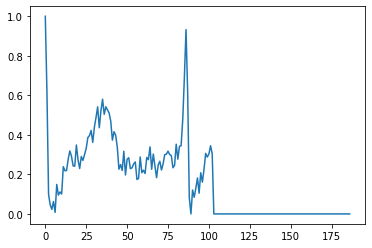

In [0]:
plt.plot(df0.iloc[10000,:-1])

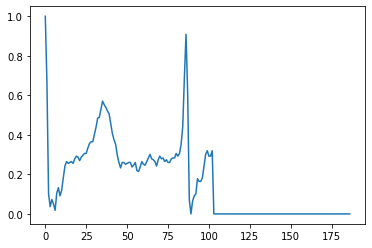

In [0]:
plt.plot(np.array(df_pos1.iloc[0,:-1]))

## Data description

There are  87553 observations in the training set and 21891 observations in the test set.  All data is scaled between 0 and 1.  Each observation has 187 features.  The features are correspond to a human heart ECG signal sampled at 125hz.  Thus the data is time dependent.  

The labels are included in the last column.  Each label can take on a value between 0 and 4.  Zero meaning normal and 1 - 4 meaning abnormal.  More to be added about abnormal conditions.  We would like to classify these time dependent signals into each of the 5 classes.


Text(0, 0.5, 'scaled signal 0-1')

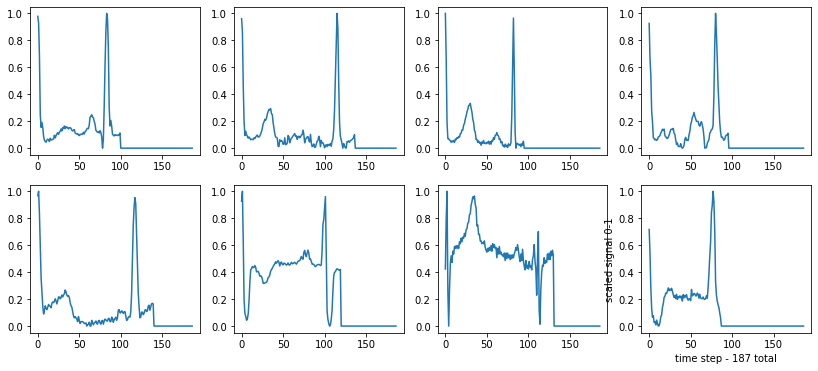

In [0]:
#sample data of ECG signal
plt.figure(figsize=(14,6))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.plot(df_train.iloc[i,:-1])
plt.xlabel('time step - 187 total')
plt.ylabel('scaled signal 0-1')

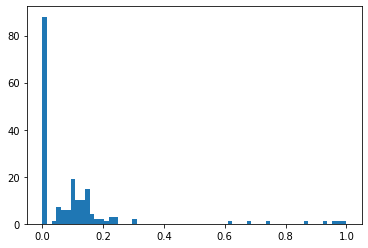

In [0]:
freq_list = plt.hist(df_train.iloc[0,:-1], 64)  #histogram of ECG signal broken down into 64 bins


In [0]:
freq_list[0]

array([88.,  0.,  1.,  7.,  6.,  6., 19., 10., 10., 15.,  4.,  2.,  2.,
        1.,  3.,  3.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.])

In [0]:
#create np arrays - make sure to shuffle data!!!
#train = np.array(df_train)
train = np.array(df0)  #use data set with noise
val = np.array(df_test)
np.random.shuffle(train)
np.random.shuffle(val)
#training data
X = np.array(train[:, 0 :-1])  #the number of features should be 187
y = np.array(train[:, -1])      #get last col only, y label
#validation data
Xval = np.array(val[:, 0 :-1])
yval = np.array(val[:, -1])
print(X.shape)
print(y.shape)
print(Xval.shape)
print(yval.shape)

(50000, 187)
(50000,)
(21892, 187)
(21892,)


In [0]:
#one hot encode the y labels
from keras.utils import to_categorical

y_d = to_categorical(y)
yval_d = to_categorical(yval)
print(y_d.shape)
print(yval_d.shape)

(50000, 5)
(21892, 5)


In [0]:
y_d

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [0]:
#convert input data, X, into discrete bins, same as digitizing input data - not the same as hot encoding
num_bins = 64  #this would be similar to resolution of the data signal
bins = np.linspace(0,1, num_bins)

In [0]:
bins 

array([0.        , 0.01587302, 0.03174603, 0.04761905, 0.06349206,
       0.07936508, 0.0952381 , 0.11111111, 0.12698413, 0.14285714,
       0.15873016, 0.17460317, 0.19047619, 0.20634921, 0.22222222,
       0.23809524, 0.25396825, 0.26984127, 0.28571429, 0.3015873 ,
       0.31746032, 0.33333333, 0.34920635, 0.36507937, 0.38095238,
       0.3968254 , 0.41269841, 0.42857143, 0.44444444, 0.46031746,
       0.47619048, 0.49206349, 0.50793651, 0.52380952, 0.53968254,
       0.55555556, 0.57142857, 0.58730159, 0.6031746 , 0.61904762,
       0.63492063, 0.65079365, 0.66666667, 0.68253968, 0.6984127 ,
       0.71428571, 0.73015873, 0.74603175, 0.76190476, 0.77777778,
       0.79365079, 0.80952381, 0.82539683, 0.84126984, 0.85714286,
       0.87301587, 0.88888889, 0.9047619 , 0.92063492, 0.93650794,
       0.95238095, 0.96825397, 0.98412698, 1.        ])

In [0]:
X_d = np.digitize(X, bins=bins)  #X is now digitized 
Xval_d = np.digitize(Xval, bins=bins) #Xval is not digitized (not hot encoded)
X_d[0]  #for example

array([57, 52, 17,  1,  4,  8, 12, 12, 15, 13, 13, 13, 21, 18, 22, 22, 22,
       24, 17, 20, 18, 25, 25, 18, 24, 26, 26, 20, 27, 29, 24, 24, 32, 28,
       28, 29, 31, 33, 36, 33, 26, 30, 25, 23, 19, 23, 17, 18, 17, 16, 18,
       17, 18, 15, 21, 19, 22, 21, 17, 16, 20, 21, 22, 19, 21, 15, 18, 21,
       15, 15, 19, 20, 20, 20, 19, 18, 15, 20, 20, 17, 18, 14, 17, 12, 16,
       21, 12, 11, 19, 17, 13, 18, 15, 14, 18, 18, 16, 15, 17, 18, 18, 14,
       17, 15, 12, 14, 15, 13, 16, 10, 18, 12, 10, 17, 17, 12, 17, 11, 16,
       15, 15, 12, 15, 15, 16, 12, 14, 17, 15, 17, 16, 17, 15, 14, 11, 14,
       11, 15, 13, 18, 12, 12, 16, 14, 17, 19, 14, 12, 13, 13, 12, 10, 18,
       14, 19, 13, 14, 19, 19, 16, 15, 17, 15, 14, 17, 14, 14, 15, 13, 14,
       16, 14, 11, 14, 16, 13, 15, 20, 17, 18, 15, 16, 17, 16, 17, 14, 16])

Text(0.5, 1.0, 'digitized ECG signal 0-64 bins')

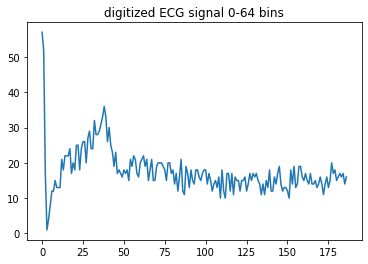

In [0]:
plt.plot(X_d[0])
plt.title('digitized ECG signal 0-64 bins')

Here is digitized plot - it doesn't look too bad.  We could increase the number of bins for more resolution.

In [0]:
#reshape data for LSTM input
X_dr = X_d.reshape(X_d.shape[0], X_d.shape[1], 1)
Xval_dr = Xval_d.reshape(Xval_d.shape[0], Xval_d.shape[1], 1)
#y_dr = y_d.reshape(y_d.shape[0], ...)


In [0]:
#confirm reshape worked
print(X_dr.shape)
print(Xval_dr.shape)

(50000, 187, 1)
(21892, 187, 1)


In [0]:
#function to report metrics
from sklearn.metrics import confusion_matrix, classification_report
def computeMetrics(name, Xv, yval_d, yval, api =False): #name is your trained model; Xv must be in 3d matrix form, for example Xval_dr; make sure you use VALIDATION DATA
    loss, acc = name.evaluate(Xv, yval_d)
    print(name, ': val loss = %.4f' %loss, 'val acc = %.4f' %acc )
    if api == True:
        p=name.predict(Xv)
        yhat = [np.argmax(i) for i in p]
    else:    
        yhat = name.predict_classes(Xv)
    print(confusion_matrix(yval, yhat))
    print(classification_report(yval, yhat, labels=[0,1,2,3,4]))


Baseline LSTM model learning rate 0.0005, Adam Optimizer

In [0]:
def buildmodel():   #not using embedding layer
    
    #input_dim is the vocab size; input_dim = num_bins
    #input_length is the number of features for an observation (same as document length); fixed at 187 in this study
    input_length = 187
    model = Sequential()
    model.add(LSTM(units=32, activation='tanh', input_shape = (input_length, 1) ))
    model.add(Dense(5, activation='softmax'))

    opt = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    #model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
    return model
    

In [0]:
#build and fit model1
model1 = buildmodel()
hist_obj = model1.fit(X_dr, y_d, epochs= 20, batch_size = 128, verbose=1, validation_data=(Xval_dr, yval_d))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 4,517
Trainable params: 4,517
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 21892 samples
Epoch 1/20
50000/50000 [==============================] - 119s 2ms/step - loss: 1.3810 - accuracy: 0.3983 - val_loss: 1.4187 - val_accuracy: 0.3393
Epoch 2/20
50000/50000 [==============================] - 120s 2ms/step - loss: 1.1054 - accuracy: 0.5735 - val_loss: 1.2764 - val_accuracy: 0.4310
Epoch 3/20
50000/50000 [==============================] - 116s 2ms/step - loss: 0.9720 - accuracy: 0.6424 - val_loss: 1.1388 - val_accuracy: 0.4926
Epoch 4/20
50000/500

In [0]:
hist_obj = model1.fit(X_dr, y_d, epochs= 20, batch_size = 128, verbose=1, validation_data=(Xval_dr, yval_d))

Train on 50000 samples, validate on 21892 samples
Epoch 1/20
50000/50000 [==============================] - 119s 2ms/step - loss: 0.6788 - accuracy: 0.7554 - val_loss: 0.9661 - val_accuracy: 0.5967
Epoch 2/20
50000/50000 [==============================] - 119s 2ms/step - loss: 0.6713 - accuracy: 0.7573 - val_loss: 0.9509 - val_accuracy: 0.5931
Epoch 3/20
50000/50000 [==============================] - 118s 2ms/step - loss: 0.6733 - accuracy: 0.7566 - val_loss: 0.8883 - val_accuracy: 0.6322
Epoch 4/20
50000/50000 [==============================] - 119s 2ms/step - loss: 0.6608 - accuracy: 0.7637 - val_loss: 0.8853 - val_accuracy: 0.6399
Epoch 5/20
50000/50000 [==============================] - 118s 2ms/step - loss: 0.6508 - accuracy: 0.7687 - val_loss: 0.8830 - val_accuracy: 0.6673
Epoch 6/20
50000/50000 [==============================] - 118s 2ms/step - loss: 0.6340 - accuracy: 0.7766 - val_loss: 0.8370 - val_accuracy: 0.6717
Epoch 7/20
50000/50000 [==============================] - 115s

In [0]:
hist_obj = model1.fit(X_dr, y_d, epochs= 50, batch_size = 128, verbose=1, validation_data=(Xval_dr, yval_d))

Train on 50000 samples, validate on 21892 samples
Epoch 1/50
50000/50000 [==============================] - 118s 2ms/step - loss: 0.6628 - accuracy: 0.7583 - val_loss: 0.6906 - val_accuracy: 0.7471
Epoch 2/50
50000/50000 [==============================] - 119s 2ms/step - loss: 0.5184 - accuracy: 0.8089 - val_loss: 0.6921 - val_accuracy: 0.7536
Epoch 3/50
50000/50000 [==============================] - 118s 2ms/step - loss: 0.5182 - accuracy: 0.8093 - val_loss: 0.6912 - val_accuracy: 0.7524
Epoch 4/50
50000/50000 [==============================] - 118s 2ms/step - loss: 0.4931 - accuracy: 0.8200 - val_loss: 0.6734 - val_accuracy: 0.7585
Epoch 5/50
50000/50000 [==============================] - 118s 2ms/step - loss: 0.5015 - accuracy: 0.8167 - val_loss: 0.6784 - val_accuracy: 0.7610
Epoch 6/50
50000/50000 [==============================] - 117s 2ms/step - loss: 0.4784 - accuracy: 0.8250 - val_loss: 0.6108 - val_accuracy: 0.7856
Epoch 7/50
50000/50000 [==============================] - 119s

In [0]:
model1.save("./drive/My Drive/Colab Notebooks/csci4622ml/finalproj/model1final_noise.h5")

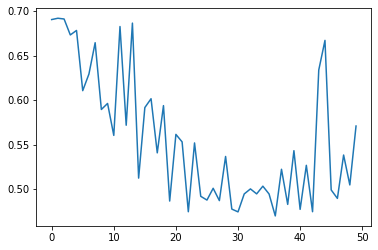

In [0]:
plt.plot(hist_obj.history['val_loss'])
plt.savefig('./drive/My Drive/Colab Notebooks/csci4622ml/finalproj/model1_noise.png')

In [0]:
from keras.models import load_model
model1final_noise = load_model("./drive/My Drive/Colab Notebooks/csci4622ml/finalproj/model1final_noise.h5")

In [0]:
computeMetrics(model1final_noise, Xval_dr, yval_d, yval, api=False)

21892/21892 [==============================] - 19s 852us/step
<keras.engine.sequential.Sequential object at 0x7f0d900c5a58> : val loss = 0.5711 val acc = 0.8281
[[15296  1873   422   328   199]
 [  175   361    16     3     1]
 [  146   106  1063    97    36]
 [   70     9     6    77     0]
 [  195    38    38     5  1332]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     18118
           1       0.15      0.65      0.25       556
           2       0.69      0.73      0.71      1448
           3       0.15      0.48      0.23       162
           4       0.85      0.83      0.84      1608

    accuracy                           0.83     21892
   macro avg       0.56      0.71      0.58     21892
weighted avg       0.91      0.83      0.86     21892

